# Initialization

Code To Mount The Drive




In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Edit system path to point to GTN Project Folder

In [25]:
import sys
sys.path.append('/content/gdrive/My Drive/GTN/')

Install Higher library

In [26]:
!pip install higher

Import the nessecary python libraries 

In [34]:
import torch
import higher
import numpy
from matplotlib import pyplot as plt
import torch.nn.functional as F

Import custom modules

In [28]:
from providers.data_provider import DataProvider
from models.LearnerNetwork import LearnerNetwork
from models.TeacherNetwork import TeacherNetwork

Create Dataloaders

In [29]:
provider = DataProvider()
train_data_loader = provider.getTrainingData(batch_size=1024)
test_data_loader = provider.getTestData()

Detect if CUDA is available

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


# Experiment 1 GTN With Full Curriculum

Create a new teacher model

In [31]:
teacher_full_curriculum = TeacherNetwork()
teacher_full_curriculum.to(device)
teacher_full_curriculum.train()
teacher_full_curriculum_optimizer = torch.optim.Adam(teacher_full_curriculum.parameters(),lr= 0.01)

Create storage variables to store meta-training data

In [32]:
meta_learning_curve_full_curriculum_train_accuracy = []
meta_learning_curve_full_curriculum_test_accuracy = []

Run The Actual Training (for 500 epochs, rather than 5000 in the paper)

In [37]:
p = numpy.random.randint(32,128, size=(500,))
q = numpy.random.randint(64,256, size=(500,))
r = numpy.random.randint(64,256, size=(500,))
for j in range(500):
  #Initialize a new learner model
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_full_curriculum.learner_optim_params[0]
  learner_momentum = teacher_full_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  teacher_full_curriculum_optimizer.zero_grad()
  with higher.innerloop_ctx(learner,optimizer,override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner,diffopt):
    #Run Inner Loop Training for 32 iterations
    for i in range(32):
      curriculum_labels = torch.tensor([k%10 for k in range(128)])
      curriculum_labels = curriculum_labels.to(device)
      curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
      curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
      noise = torch.cat([teacher_full_curriculum.learner_input[i], curriculum_labels_one_hot], dim=-1)
      noise.to(device)
      X = teacher_full_curriculum(noise)
      y = curriculum_labels
      X,y = X.to(device),y.to(device)
      pred = flearner(X)
      loss = F.nll_loss(pred,y)
      diffopt.step(loss)
    #Calculate meta-loss
    X,y = next(iter(train_data_loader))
    X,y = X.to(device),y.to(device)
    pred = flearner(X)
    loss = F.nll_loss(pred, y)
    loss.backward()
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    train_accuracy = correct*100
    meta_learning_curve_full_curriculum_train_accuracy.append(correct)
    teacher_full_curriculum_optimizer.step()
    #Do some validation to get meta-training data
    X,y = next(iter(test_data_loader))
    X,y = X.to(device),y.to(device)
    pred = flearner(X)
    loss = F.nll_loss(pred, y)
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    meta_learning_curve_full_curriculum_test_accuracy.append(correct)
    test_accuracy = correct*100
    #Output training result every 25th iteration
    if(j%25 == 0): print(f"{j} train accuracy {train_accuracy}% test accuracy {test_accuracy}%")

0 train accuracy 69.7265625% test accuracy 70.21484375%
25 train accuracy 98.14453125% test accuracy 94.921875%
50 train accuracy 97.65625% test accuracy 94.82421875%
75 train accuracy 95.99609375% test accuracy 95.41015625%
100 train accuracy 96.875% test accuracy 94.140625%
125 train accuracy 96.484375% test accuracy 94.62890625%
150 train accuracy 96.19140625% test accuracy 95.3125%
175 train accuracy 95.99609375% test accuracy 94.04296875%
200 train accuracy 96.484375% test accuracy 94.53125%
225 train accuracy 95.41015625% test accuracy 95.01953125%
250 train accuracy 97.16796875% test accuracy 94.23828125%
275 train accuracy 96.97265625% test accuracy 93.84765625%
300 train accuracy 97.0703125% test accuracy 94.7265625%
325 train accuracy 97.16796875% test accuracy 95.80078125%
350 train accuracy 96.97265625% test accuracy 95.21484375%
375 train accuracy 97.0703125% test accuracy 95.60546875%
400 train accuracy 97.4609375% test accuracy 94.62890625%
425 train accuracy 97.36328125

We now do some benchmarking on the model

In [43]:
p = numpy.random.randint(32,128, size=(500,))
q = numpy.random.randint(64,256, size=(500,))
r = numpy.random.randint(64,256, size=(500,))
train_result_full_curriculum_mnist = []
for j in range(500):
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_full_curriculum.learner_optim_params[0]
  learner_momentum = teacher_full_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  for i in range(32):
    curriculum_labels = torch.tensor([k%10 for k in range(128)])
    curriculum_labels = curriculum_labels.to(device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([teacher_full_curriculum.learner_input[i], curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_full_curriculum(noise)
    y = curriculum_labels
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  X,y = next(iter(test_data_loader))
  X,y = X.to(device),y.to(device)
  pred = learner(X)
  loss = F.nll_loss(pred, y)
  output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct = 0
  correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= 1024
  train_result_full_curriculum_mnist.append(correct)
  if(j%25 == 0): print(f"{j} test accuracy {correct}")
print(f"n: 500 mean: {numpy.mean(train_result_full_curriculum_mnist)} standard deviation: {numpy.std(train_result_full_curriculum_mnist)}")

0 test accuracy 0.953125
25 test accuracy 0.9638671875
50 test accuracy 0.9560546875
75 test accuracy 0.958984375
100 test accuracy 0.9580078125
125 test accuracy 0.955078125
150 test accuracy 0.9541015625
175 test accuracy 0.9599609375
200 test accuracy 0.962890625
225 test accuracy 0.951171875
250 test accuracy 0.9501953125
275 test accuracy 0.9501953125
300 test accuracy 0.947265625
325 test accuracy 0.955078125
350 test accuracy 0.9541015625
375 test accuracy 0.955078125
400 test accuracy 0.951171875
425 test accuracy 0.9482421875
450 test accuracy 0.9541015625
475 test accuracy 0.94921875
n: 500 mean: 0.952478515625 standard deviation: 0.004980636869098788


# Experiment 2 GTN Training With No Curriculum

Create a new teacher model

In [46]:
teacher_no_curriculum = TeacherNetwork()
teacher_no_curriculum.to(device)
teacher_no_curriculum.train()
teacher_no_curriculum_optimizer = torch.optim.Adam(teacher_no_curriculum.parameters(),lr= 0.01)

Create storage to store meta-training data

In [45]:
meta_learning_curve_no_curriculum_train_accuracy = []
meta_learning_curve_no_curriculum_test_accuracy = []

Run The Actual Training (for 500 epochs, rather than 5000 in the paper)

In [47]:
p = numpy.random.randint(32,128, size=(500,))
q = numpy.random.randint(64,256, size=(500,))
r = numpy.random.randint(64,256, size=(500,))
for j in range(500):
  #Initialize a new learner model
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_no_curriculum.learner_optim_params[0]
  learner_momentum = teacher_no_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  teacher_no_curriculum_optimizer.zero_grad()
  #Run inner loop training for 32 iteration
  with higher.innerloop_ctx(learner,optimizer,override={'lr': [learner_lr], 'momentum': [learner_momentum]}) as (flearner,diffopt):
    for i in range(32):
      curriculum_labels = torch.randint(10, size=(128,), dtype=torch.int64, device = device)
      curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
      curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
      noise = torch.cat([torch.randn(128, 128,device = device), curriculum_labels_one_hot], dim=-1)
      noise.to(device)
      X = teacher_no_curriculum(noise)
      y = curriculum_labels
      X,y = X.to(device),y.to(device)
      pred = flearner(X)
      loss = F.nll_loss(pred,y)
      diffopt.step(loss)
    #Calculate meta-loss
    X,y = next(iter(train_data_loader))
    X,y = X.to(device),y.to(device)
    pred = flearner(X)
    loss = F.nll_loss(pred, y)
    loss.backward()
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    train_accuracy = correct*100
    meta_learning_curve_no_curriculum_train_accuracy.append(correct)
    teacher_no_curriculum_optimizer.step()
    #Do some validation to get meta-training data
    X,y = next(iter(test_data_loader))
    X,y = X.to(device),y.to(device)
    pred = flearner(X)
    loss = F.nll_loss(pred, y)
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    meta_learning_curve_no_curriculum_test_accuracy.append(correct)
    test_accuracy = correct*100
    #Output training result every 25th iteration
    if(j%25 == 0): print(f"{j} train accuracy {train_accuracy}% test accuracy {test_accuracy}%")

0 train accuracy 8.59375% test accuracy 8.984375%
25 train accuracy 91.796875% test accuracy 89.0625%
50 train accuracy 92.08984375% test accuracy 90.4296875%
75 train accuracy 92.7734375% test accuracy 91.69921875%
100 train accuracy 93.45703125% test accuracy 91.015625%
125 train accuracy 94.43359375% test accuracy 92.67578125%
150 train accuracy 93.359375% test accuracy 91.30859375%
175 train accuracy 94.43359375% test accuracy 93.06640625%
200 train accuracy 95.01953125% test accuracy 91.796875%
225 train accuracy 96.484375% test accuracy 93.45703125%
250 train accuracy 96.58203125% test accuracy 91.9921875%
275 train accuracy 94.53125% test accuracy 93.75%
300 train accuracy 95.5078125% test accuracy 92.96875%
325 train accuracy 95.3125% test accuracy 93.84765625%
350 train accuracy 96.97265625% test accuracy 94.82421875%
375 train accuracy 95.3125% test accuracy 93.65234375%
400 train accuracy 95.703125% test accuracy 93.359375%
425 train accuracy 94.82421875% test accuracy 93.75

Again, we now do some benchmarking on our models

In [50]:
p = numpy.random.randint(32,128, size=(500,))
q = numpy.random.randint(64,256, size=(500,))
r = numpy.random.randint(64,256, size=(500,))
train_result_no_curriculum_mnist = []
for j in range(500):
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_no_curriculum.learner_optim_params[0]
  learner_momentum = teacher_no_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  for i in range(32):
    curriculum_labels = torch.randint(10, size=(128,), dtype=torch.int64, device = device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([torch.randn(128, 128,device = device), curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_no_curriculum(noise)
    y = curriculum_labels
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  X,y = next(iter(test_data_loader))
  X,y = X.to(device),y.to(device)
  pred = learner(X)
  loss = F.nll_loss(pred, y)
  output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct = 0
  correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= 1024
  train_result_full_curriculum_mnist.append(correct)
  if(j%25 == 0): print(f"{j} test accuracy {correct}")
print(f"n: 500 mean: {numpy.mean(train_result_full_curriculum_mnist)} standard deviation: {numpy.std(train_result_full_curriculum_mnist)}")

0 test accuracy 0.947265625
25 test accuracy 0.9501953125
50 test accuracy 0.923828125
75 test accuracy 0.9462890625
100 test accuracy 0.9404296875
125 test accuracy 0.9306640625
150 test accuracy 0.9384765625
175 test accuracy 0.94140625
200 test accuracy 0.9375
225 test accuracy 0.9326171875
250 test accuracy 0.9404296875
275 test accuracy 0.947265625
300 test accuracy 0.9453125
325 test accuracy 0.9306640625
350 test accuracy 0.943359375
375 test accuracy 0.947265625
400 test accuracy 0.9453125
425 test accuracy 0.9296875
450 test accuracy 0.953125
475 test accuracy 0.9501953125
n: 500 mean: 0.9452395833333334 standard deviation: 0.008291762768365822


# Result Analysis



Display GTN generated images (full curriculum)



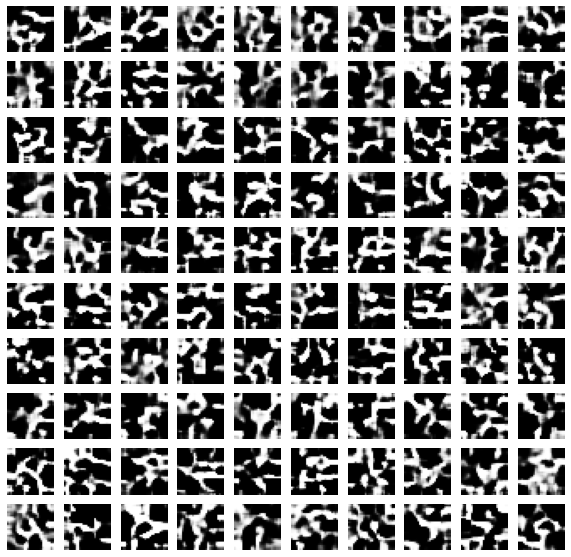

In [55]:
l = []
y = []
for i in range(32):
    curriculum_labels = torch.tensor([k%10 for k in range(128)])
    curriculum_labels = curriculum_labels.to(device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([teacher_full_curriculum.learner_input[i], curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_full_curriculum(noise).squeeze(1)
    l.append(X)
    y.append(curriculum_labels)
    
d = torch.cat(l,dim=0)
t = torch.cat(y,dim=0)
ll = t.cpu().detach().numpy()
m = numpy.array([])
for i in range(10):
    m = numpy.append(m,numpy.random.choice(numpy.argwhere(ll==i).squeeze(1),size=(10,),replace=False))
X = d.cpu().detach().numpy()[m.astype(int)]
fig = plt.figure(figsize=(10,10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X[i-1], cmap='gray')
plt.show()

Display GTN generated images (no curriculum)

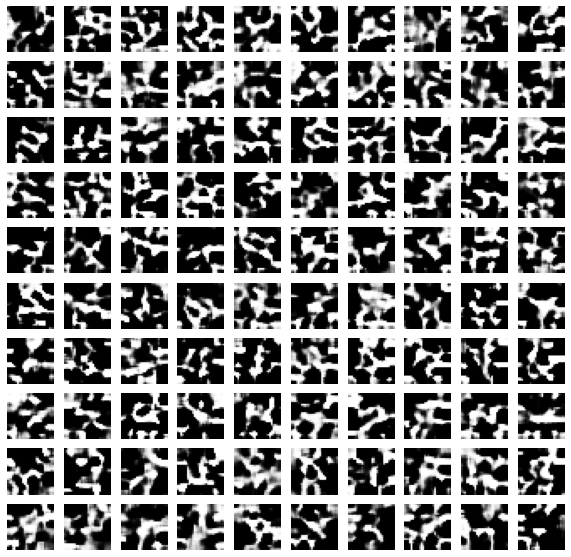

In [52]:
l = []
y = []
for i in range(32):
    curriculum_labels = torch.randint(10, size=(128,), dtype=torch.int64, device = device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([torch.randn(128, 128,device = device), curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_no_curriculum(noise).squeeze(1)
    l.append(X)
    y.append(curriculum_labels)
    
d = torch.cat(l,dim=0)
t = torch.cat(y,dim=0)
ll = t.cpu().detach().numpy()
m = numpy.array([])
for i in range(10):
    m = numpy.append(m,numpy.random.choice(numpy.argwhere(ll==i).squeeze(1),size=(10,),replace=False))
X = d.cpu().detach().numpy()[m.astype(int)]
fig = plt.figure(figsize=(10,10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X[i-1], cmap='gray')
plt.show()

Compare meta-training curve


(0.85, 1.0)

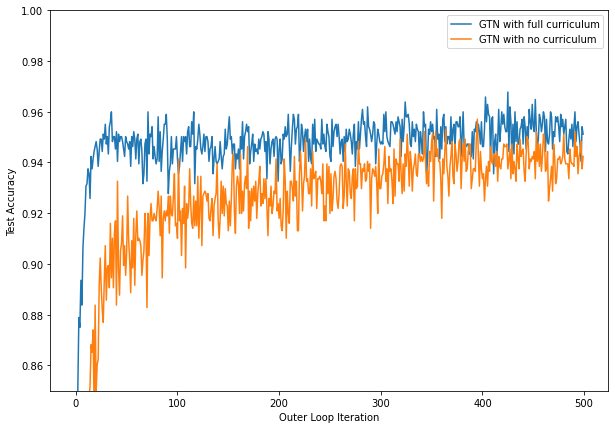

In [56]:
plt.subplots(figsize=(10, 7))
plt.plot(meta_learning_curve_full_curriculum_test_accuracy,label='GTN with full curriculum')
plt.plot(meta_learning_curve_no_curriculum_test_accuracy,label='GTN with no curriculum')
plt.ylabel('Test Accuracy')
plt.xlabel('Outer Loop Iteration')
plt.legend()
plt.ylim(0.85,1)

Compare Training Curve

Text(0, 0.5, 'Test Accuracy')

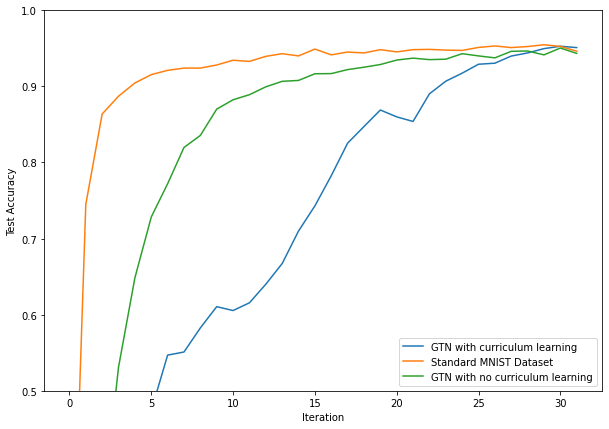

In [59]:
a = numpy.zeros(shape=(5,32))
b = numpy.zeros(shape=(5,32))
c = numpy.zeros(shape=(5,32))
p = numpy.random.randint(32,128, size=(5,))
q = numpy.random.randint(64,256, size=(5,))
r = numpy.random.randint(64,256, size=(5,))
train_dataloader = provider.getTrainingData()

for j in range(5):
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_full_curriculum.learner_optim_params[0]
  learner_momentum = teacher_full_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  for i in range(32):
    X,y = next(iter(test_data_loader))
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred, y)
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    a[j][i] = correct
    curriculum_labels = torch.tensor([k%10 for k in range(128)])
    curriculum_labels = curriculum_labels.to(device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([teacher_full_curriculum.learner_input[i], curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_full_curriculum(noise)
    y = curriculum_labels
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  optimizer = torch.optim.Adam(learner.parameters(),betas = (0.9, 0.999), lr=0.01)
  train_data = provider.getTrainingData(batch_size=128)
  for i in range(32):
    X,y = next(iter(test_data_loader))
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred, y)
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    b[j][i] = correct
    X,y = next(iter(train_data))
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  learner = LearnerNetwork(p[j],q[j],r[j])
  learner.to(device)
  learner.train()
  learner_lr = teacher_no_curriculum.learner_optim_params[0]
  learner_momentum = teacher_no_curriculum.learner_optim_params[1]
  optimizer = torch.optim.SGD(learner.parameters(), lr=learner_lr.item(), momentum=learner_momentum.item())
  for i in range(32):
    X,y = next(iter(test_data_loader))
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred, y)
    output = pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = 0
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= 1024
    c[j][i] = correct
    curriculum_labels = torch.randint(10, size=(128,), dtype=torch.int64, device = device)
    curriculum_labels_one_hot = torch.zeros(128, 10, device = device)
    curriculum_labels_one_hot.scatter_(1, curriculum_labels.unsqueeze(-1), 1)
    noise = torch.cat([torch.randn(128, 128,device = device), curriculum_labels_one_hot], dim=-1)
    noise.to(device)
    X = teacher_no_curriculum(noise)
    y = curriculum_labels
    X,y = X.to(device),y.to(device)
    pred = learner(X)
    loss = F.nll_loss(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

a1 = numpy.mean(a,axis=0)
b1 = numpy.mean(b,axis=0)
c1 = numpy.mean(c,axis=0)
plt.subplots(figsize=(10, 7))
plt.plot(a1,label='GTN with curriculum learning')
plt.plot(b1,label='Standard MNIST Dataset')
plt.plot(c1,label='GTN with no curriculum learning')
plt.legend()
plt.ylim(0.5,1)
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy')